# Robot Learning Assignment

### 1. Develop an implementation of the game BeCareful, a simplified version of Blackjack:
The game is played with an infinite deck of cards (i.e. cards are sampled with replacement).
Each draw from the deck results in a value between 3 and 12 (uniformly distributed) with a color
of red (probability .3) or black (probability .7). <br>

There are no aces or picture (face) cards in this game.

At the start of the game, both the player and the dealer draw one black card (fully observed) 
Each turn the player may either stick or hit.<br>
If the player hits then he or she draws another card from the deck.<br>
If the player sticks he or she receives no further cards.<br>
The values of the player's cards are added (black cards) or subtracted (red cards).<br>
If the player's sum exceeds 21, or becomes less than 1, then she “goes bust" and loses the game
(reward -1).<br>
If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 15
or greater, and hits otherwise.


If the dealer goes bust, then the player wins; otherwise, the outcome
{ win (reward +1), lose (reward -1), or draw (reward 0) } is the player with the largest sum.<br>

Specifically, write a function (s′, r) = advance(s, a), which takes as input a state s (dealer’s first
card 3–12 and the player’s sum 1–21), and an action a (hit or stick), and returns a sample of the
next state s′ (which may be terminal if the game is finished) and reward r ∈ {1, 0, -1} for winning,
draw, and loosing. All non-terminal rewards are zero. There is no discounting (γ = 1). You should
treat the dealer’s moves as part of the environment, i.e. calling advance(s, stick) will play out the
dealer’s cards and return the final reward and terminal state. 

In [1]:
import enum 
import numpy as np

In [2]:
  
# creating enumerations using class 
class Action(enum.Enum): 
    hit = 0
    stick = 1

# -1 for red card and +1 for black    
def getColor():
    prob = np.random.uniform(0,1)
    if prob <= 0.3:
        return -1
    else:
        return 1

# function for returning card value
def getValue():
    return np.random.randint(3,13)

# function for returning card
def hit():
    return getColor(),getValue()



def advance(state,action):
    dealerfirstCard = state[0]
    dealerSum = dealerfirstCard
    playerSum = state[1]
    
    if action == Action.hit:
        color,card = hit()
        playerSum = playerSum  + color*card
        
        ## busted
        if playerSum < 1 or playerSum > 21:
            return (dealerfirstCard,playerSum),-1,True
        else:
            return (dealerfirstCard,playerSum), 0,False
    
    else:

        # dealer hitting when dealer's sum is less than 15
        while dealerSum < 15:
            color,card = hit()
            dealerSum += color*card

            if dealerSum < 1 or dealerSum > 21:
                return (dealerfirstCard,playerSum),1, True
        
        
        if dealerSum > playerSum:
             return (dealerfirstCard,playerSum),-1, True
        elif dealerSum < playerSum:
             return (dealerfirstCard,playerSum),1, True
        else:
             return (dealerfirstCard,playerSum),0, True

        
        
    



### 2. Implement Sarsa(λ) for BeCareful.
Initialise the value function Q(s, a) to zero.
Use a time-varying scalar step-size of $$ α_{t} = 1/N(s_{t} , a_{t} )$$ and an ε-greedy exploration strategy with<br>
 $$ε_{{t}}=N_{0} /(N_{0} + N_{(s_{t})})$$  $$,where\  N_{0} = 10$$ is a constant, N(s) is the number of times state s has been
visited, and N(s, a) is the number of times action a has been selected from state s.
Run the algorithm with parameter values λ ∈ {0, 0.1, 0.2, ..., 1}. Stop exploration and learning
after 1000 episodes and plot the accumulated reward for the next 100 episodes against λ.

In [3]:
from collections import defaultdict


In [4]:
def initialise():
    Q = defaultdict(lambda: np.zeros(len(A)))
    e = defaultdict(float)
    N_s = defaultdict(int)
    N_s_a = defaultdict(int)
    
    return Q,e,N_s,N_s_a

TOTAL_EPISODES = 1000

TEST_EPISODES = 100

A = [Action.hit, Action.stick]
N_0 = 10
gamma = 1

lambdas = np.linspace(0,1,num=11)


In [5]:
# method to return epsilon greedy action
def epsilon_greedy(Q,state,epsilon):
    actionProbs = np.ones(len(A))*epsilon/len(A)
    bestAction = np.argmax(Q[state])
    actionProbs[bestAction] += 1 - epsilon
    
    return np.random.choice(A,p=actionProbs)

In [6]:
# method to return greedy action
def greedy(Q,state):
    bestAction = np.argmax(Q[state])
    return A[bestAction]

In [7]:

epsilon = lambda currentState: N_0/(N_0 + N_s[currentState])
learning_rate = lambda state,action: 1/N_s_a[state,action]

In [8]:
# for accumulating rewards
reward_sum = np.zeros_like(lambdas)

In [9]:
for i,lambda_ in enumerate(lambdas):
    Q,e,N_s,N_s_a = initialise()

    for episode in range(TOTAL_EPISODES):
        
        # getting random black cards
        playerSum = getValue()
        dealerCard = getValue()
        
        
        #defining the state
        currentState = (dealerCard,playerSum)
        
        #incrementing the count for the state
        N_s[currentState] += 1
        
        action = epsilon_greedy(Q,currentState,epsilon(currentState))
        
        while True:
            # performing action
            nextState,reward,endOfEpisode = advance(currentState,action)

            # incrementing count for the state action pair
            N_s_a[currentState,action] += 1
            nextAction = epsilon_greedy(Q,nextState,epsilon(nextState))
            error = reward + gamma*Q[nextState][nextAction.value] - Q[currentState][action.value]
            
            #incrementing eligibiity for the state action
            e[currentState,action] += 1
            
            # updating Q values for visited state action pairs
            for s,a in N_s_a.keys():
                Q[s][a.value] = Q[s][a.value] + learning_rate(s,a)*error*e[s,a]
                e[s,a] = gamma*lambda_*e[s,a]
            
            
            currentState = nextState
            N_s[currentState] += 1

            action = nextAction
            
            if endOfEpisode :

                break
             
        
    
    
    for episode in range(TEST_EPISODES):
        
        playerSum = getValue()
        dealerCard = getValue()
        
        currentState = (dealerCard,playerSum)
        # performing action greedily
        action = greedy(Q,currentState)
        while True:
            
            nextState,reward,endOfEpisode = advance(currentState,action)
            currentState = nextState
            action = greedy(Q,currentState)
            if endOfEpisode:
                reward_sum[i] += reward
                break
        

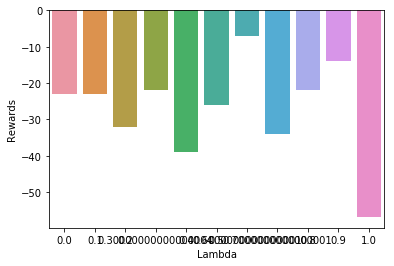

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
data = pd.DataFrame({"Lambda":lambdas, "Rewards": reward_sum})

sns.barplot(x="Lambda",y="Rewards",data=data)